Frame 39: 288 trajectories present.


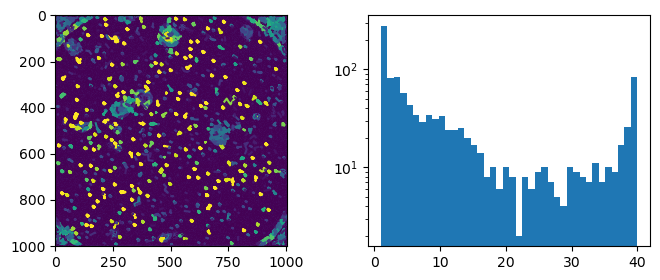

Reload original stack...
Minimum time = 0, maximum time = 39; Stack length: 40
Found 168 tracks in the reference frame


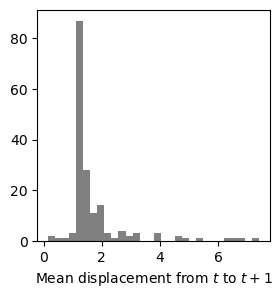

Max accepted displacement = 6.6315621653339365


100%|███████████████████████████████████████████| 40/40 [00:30<00:00,  1.31it/s]


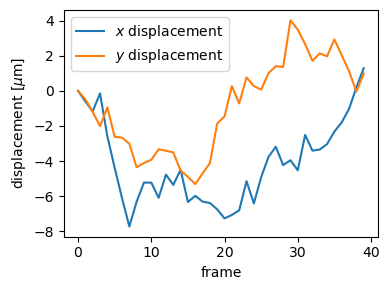

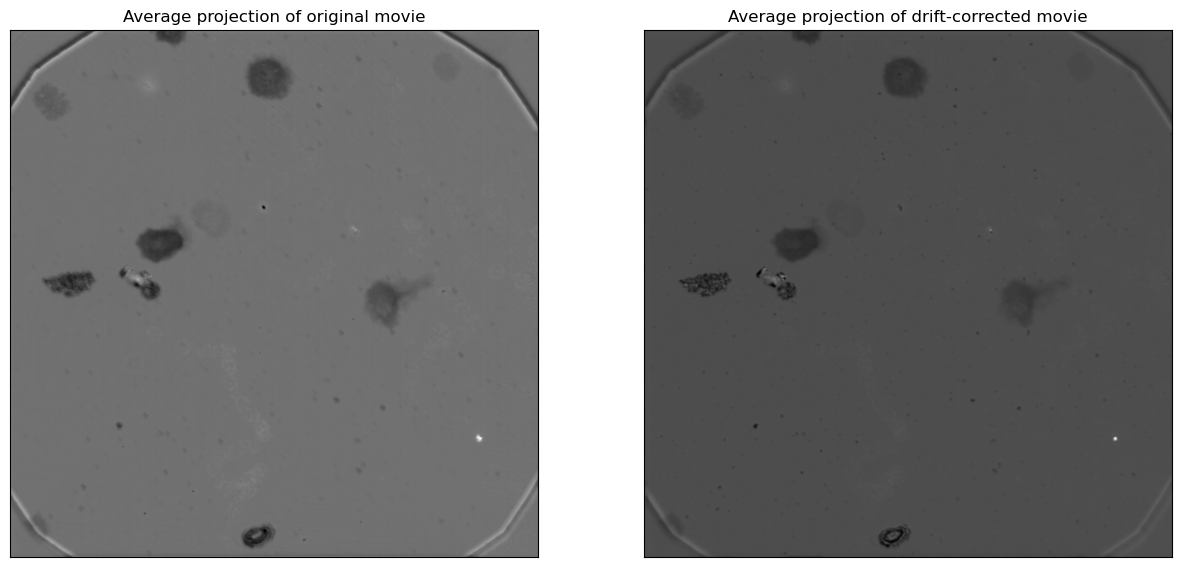

In [1]:
from tifffile import imread,imwrite
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
from matplotlib.cm import viridis
import os
from tqdm import tqdm
import gc
from scipy.ndimage import fourier_shift
from natsort import natsorted

def plot_displacement(frames,x_disp,y_disp,filename):
	"""
	Plots the drift along the X and Y axis of the image, 
	measured from the trajectories
	
	Parameters
	----------
	
	frames: 1D numpy array
		the time frame associated to each displacement value
	x_disp: 1D numpy array
		the X-displacement as a function of time in µm
	y_disp: 1D numpy array
		the Y-displacement as a function of time in µm
	filename: str
		the export filename for the plot
	
	Returns
	-------
	
	matplotlib figure
	
	"""
	plt.figure(figsize=(4,3))
	plt.plot(frames,x_disp,label=r"$x$ displacement")
	plt.plot(frames,y_disp,label=r"$y$ displacement")
	plt.xlabel('frame')
	plt.ylabel(r'displacement [$\mu$m]')
	plt.legend()
	plt.tight_layout()
	plt.savefig(filename,dpi=300)
	plt.pause(3)
	plt.close()


def fourier_shift_frame(frame,shift_x,shift_y,calibration):
	"""
	Sequentially Fourier transform, apply a shift
	and Fourier invert an image
	
	Parameters
	----------
	
	frame: 2D numpy array
		the image to shift correct
	shift_x, shift_y: float
		the shift in pixel unit to correct in X and Y
	calibration:
		pixel to µm calibration (e.g. 1 px = 0.1 µm)
	
	Returns
	-------
	
	2D numpy array
		The shift corrected image
	
	"""

	#Fourier transform, apply shift, Fourier invert
	to_align = np.copy(frame)
	fft = np.fft.fft2(to_align)
	fft_shift = fourier_shift(fft,shift=[-shift_y/calibration,-shift_x/calibration])
	fftm1 = np.fft.ifft2(fft_shift)

	# Export aligned frame
	#imwrite(filename,np.array(np.absolute(fftm1),dtype='uint16'))

	del to_align
	del fft
	del fft_shift
	
	return(np.array(np.absolute(fftm1),dtype='float'))

def mean_displacement(x,y,times):
	"""
	Take a single trajectory and compute the average displacement
	
	Parameters
	----------
	
	x,y: 1D numpy array
		the positions x, y as a function of time
	time: 1D numpy array
		the time points paired with (X,Y)
		
	Returns
	-------
	
	float
		the average displacement from t to t+1
	
	"""
	fullrange = list(np.linspace(min(times),max(times),int(max(times)-min(times))+1)) #to include gaps in average
	s=0
	for p in range(0,len(x)-1):
		s+= np.sqrt((x[p+1]-x[p])**2+(y[p+1]-y[p])**2)
	return(s/len(fullrange))

def detect_and_track_surface_defects(stack, diameter=10, search_distance=10, batch_params=None, link_params=None, plot=True):
    
    f = tp.batch(stack, diameter, **batch_params)
    tracks = tp.link(f, search_distance, **link_params)
    tracks = tracks.rename(columns={'particle': 'TRACK_ID', 'x': 'POSITION_X', 'y': 'POSITION_Y', 'frame': 'FRAME'})
    tracks = tracks.sort_values(by=['TRACK_ID','FRAME'])    

    if plot:
        fig,ax = plt.subplots(1,2,figsize=(8,3))
        ax[0].imshow(stack[-1],cmap="viridis",interpolation='none')
        tracklength = []
        for tid,group in tracks.groupby('TRACK_ID'):
            x = group['POSITION_X']
            y = group['POSITION_Y']
            c = viridis(len(x)/len(stack))
            ax[0].plot(x,y,c=c)
            tracklength.append(len(x))

        ax[1].hist(tracklength,bins=len(stack))
        ax[1].set_yscale('log')
        plt.show()
    
    return tracks

from celldetective.tracking import clean_trajectories

def fourier_correct(stack, tracks, plot_disp=True, plot_drift=True, compare_before_after=True):
    
    tracks = clean_trajectories(tracks, minimum_tracklength=int(0.8*len(stack)))
    times = np.unique(tracks['FRAME'].to_numpy()) #extract times for which tracks are available
    fullrange = list(np.linspace(min(times),max(times),int(max(times)-min(times))+1)) #all times
    framediff = list(set(fullrange) - set(list(times))) #missing frames
    print(f"Minimum time = {np.amin(times)}, maximum time = {np.amax(times)}; Stack length: {len(stack)}")

    mean_displacement_x = []; mean_displacement_y = [];

    # Find tracks existing in the reference frame
    exists_at_ref = tracks['FRAME'] == 0
    tracks_ref = tracks[exists_at_ref].TRACK_ID.unique()
    print(f"Found {len(tracks_ref)} tracks in the reference frame")
    
    #initialize displacement fields to 0.0
    mean_displacement_x_at_t = np.zeros(len(fullrange)); mean_displacement_y_at_t = np.zeros(len(fullrange));

    #Compute the mean displacement of all tracks and filter out outliers
    confinement_number = []
    tracklist = []
    
    for tid,group in tracks.groupby('TRACK_ID'):
        x = group['POSITION_X'].to_numpy()
        y = group['POSITION_Y'].to_numpy()
        frames = group['FRAME'].to_numpy()
        c = mean_displacement(x,y,frames)
        confinement_number.append(c)
        tracklist.append(tid)

    if plot_disp:
        fig,ax = plt.subplots(figsize=(3,3))
        ax.hist(confinement_number,bins=30,color="gray")
        plt.xlabel(r"Mean displacement from $t$ to $t+1$")
        plt.show()

    c_threshold = np.percentile(confinement_number,99)
    print(f"Max accepted displacement = {c_threshold}")
    
    aligned_stack = []

    #Loop over all frames and align when tracking information is available
    for t in tqdm(times):
        gc.collect()

        ref = 0
        #print(f"Aligning frame {t} out of {max(times)}... ")
        exists_at_t = tracks['FRAME'] == t # Subtable of spots existing at time t
        tracks_t = tracks[exists_at_t].TRACK_ID.unique() # Get tracks associated to those spots
        track_intersect = np.intersect1d(tracks_ref,tracks_t) # Find intersection of tracks between ref and t

        #Routine to align frames with no intersect to the last frame that was aligned, by chain rule
        if len(track_intersect)<1:
            s=1
            while len(track_intersect)==0:
                exists_at_new_ref = tracks['FRAME'] == int(t-s)
                tracks_new_ref = tracks[exists_at_new_ref].TRACK_ID.unique()
                s+=1
                if s==20:
                    print("No reference time could be found... The algorithm will not function properly... ")
                    break
            ref = int(t-s+1)
            print("New reference time = ",ref)

        # Use track matches to compute the drift
        dx = []; dy = []; 
        for tid in track_intersect:
            track_at_t = tracks[(tracks['TRACK_ID']==tid) & (tracks['FRAME']==t)]
            track_at_ref = tracks[(tracks['TRACK_ID']==tid) & (tracks['FRAME']==ref)]
            c_value = confinement_number[int(np.where(tracklist==tid)[0])]

            xt = track_at_t['POSITION_X'].to_numpy()[0]
            yt = track_at_t['POSITION_Y'].to_numpy()[0]
            if ref==0:
                x0 = track_at_ref['POSITION_X'].to_numpy()[0]
                y0 = track_at_ref['POSITION_Y'].to_numpy()[0]
            else:
                #print(ref)
                #print(len(mean_displacement_x_at_t))
                x0 = track_at_ref['POSITION_X'].to_numpy()[0] - mean_displacement_x_at_t[int(np.where(times==ref)[0])]
                y0 = track_at_ref['POSITION_Y'].to_numpy()[0] - mean_displacement_y_at_t[int(np.where(times==ref)[0])]
            if c_value<c_threshold:
                dx.append(xt - x0)
                dy.append(yt - y0)

        if len(dx)>1:
            mean_dx = np.median(dx); mean_dy = np.median(dy);
            mean_displacement_x_at_t[int(t)] = mean_dx
            mean_displacement_y_at_t[int(t)] = mean_dy
            img_t = stack[t]
            fftm1 = fourier_shift_frame(img_t,mean_dx,mean_dy,1)
            aligned_stack.append(fftm1)

            del img_t
            del fftm1

        else:
            framediff = np.append(framediff,t)
            framediff = np.sort(framediff)
        
    if plot_drift:
        plot_displacement(np.array(fullrange),mean_displacement_x_at_t,mean_displacement_y_at_t,pos+"displacement_profile.png")
    
    if compare_before_after:
        
        fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
        ax1.imshow(np.mean(stack,axis=0),cmap="gray",interpolation='spline16')
        ax1.set_xticks([]); ax1.set_yticks([]);
        ax1.set_title("Average projection of original movie")
        ax2.imshow(np.mean(aligned_stack,axis=0),cmap="gray",interpolation='spline16')
        ax2.set_xticks([]); ax2.set_yticks([]);
        ax2.set_title("Average projection of drift-corrected movie")
        plt.show()    
    
    assert len(aligned_stack)==len(stack),'The stacks do not have the same length...'
    return np.array(aligned_stack)


exp_dir = '.' + os.sep
prefix = 'Norm'

diameter = 7 #odd
invert = False
spot_minmass = 0.05 # decrease to get more spots
separation = 20
search_distance = 20
memory = 5 # increase if there are blurry frames for which spots cannot be seen

batch_params = {'minmass': spot_minmass, 'invert': invert, 'separation': separation}
link_params = {'memory': memory}


wells = natsorted(glob(exp_dir + "W*" + os.sep))
for widx,well in enumerate(wells[1:]):
    positions = natsorted(glob(well + well.split(os.sep)[-2][1:] + '*' + os.sep))
    for pidx, pos in enumerate(positions):
        movie_path = pos + os.sep.join(['movie',f'{prefix}*.tif'])
        movies = glob(movie_path)
        if len(movies) > 0:
            
            stack = imread(movies[0]).astype(float)
            stack = np.subtract(stack, 1)
            stack = np.abs(stack)
            
            print(f'Stack of shape {stack.shape} successfully loaded...')
            print('Detecting spots...')
            
            try:
                tracks = detect_and_track_surface_defects(stack, diameter=diameter, 
                                                          search_distance=search_distance,
                                                          batch_params=batch_params, 
                                                          link_params=link_params,
                                                          plot=True
                                                         )
                print('Reload original stack...')
                stack = imread(movies[0]).astype(float)
                stack = fourier_correct(stack, tracks)
                imwrite(os.sep.join([os.path.split(movies[0])[0],'Aligned_'+os.path.split(movies[0])[-1]]), stack)

                del stack
                del tracks
                gc.collect()
            except Exception as e:
                print(f'Error {e}... Continue...')
                continue
                
            